# [ Introduction](Introduction.ipynb)

# [ Données météorologiques](Donnes_meteo.ipynb)

# [ Modèle Thermique et modèle mathematique](Modele_thermique.ipynb)

# [Implementation et resultats : simulation stationnaire, polystrène expansé ](Stationnaire_cas.ipynb)

# [ Implementation et resultats : simulation stationnaire, laine de mouton ](laine.ipynb)

# [ Estimation degre-heures](degre-hours.ipynb)

# [ Modèle Mathematique, implementation et resultats : simulation stationnaire à répresetation état-spatiel ](state-space.ipynb)

# Simulation dynamique
La méthode Dynamic Models for Building Energy Management (dm4bem) propose une approche innovante pour modéliser le transfert de chaleur et de masse dans les bâtiments, 
avec des applications en ingénierie de contrôle. Contrairement aux outils de simulation existants, dm4bem utilise des circuits thermiques pondérés et dirigés, également 
appelés réseaux thermiques, pour modéliser les échanges thermiques. Cette approche permet de créer des modèles complexes en assemblant des circuits et de les transformer 
ensuite en représentations d'état.

Paramètres Principaux de la Méthode dm4bem :

1. Circuits Thermiques : 
 - Les modèles thermiques sont basés sur des circuits thermiques, où les nœuds représentent des températures homogènes et les liens dirigés représentent 
 les flux de chaleur entre les nœuds.

2. Structures de Données : 
 - La méthode propose une structure de données spécifique pour les circuits thermiques, comprenant une matrice d'incidence branche-nœud, des vecteurs 
 pour les matrices de conductance et de capacité, ainsi que des vecteurs pour les sources de température et de débit.

3. Représentation d'État :
   - La représentation d'état est obtenue en éliminant les équations algébriques du système d'équations différentielles-algébriques, fournissant une matrice d'état, 
   une matrice de commande, une matrice d'observation, une matrice d'action directe et une table de correspondance entre les branches et les nœuds avec sources.

4. Modélisation du Bâtiment :
   - Les murs, souvent modélisés comme des circuits thermiques, sont décrits par des fichiers contenant les propriétés thermophysiques des matériaux et des données 
   spécifiques des murs, telles que la surface, les sources de température et de débit, et les coefficients de convection et de rayonnement.

5. Algorithme d'Assemblage :
   - Les circuits thermiques peuvent être assemblés en un seul circuit à l'aide d'une matrice d'assemblage ou de listes d'assemblage, facilitant la modélisation de bâtiments 
   complexes.

6. Algorithme de Transformation :
   - L'élimination des équations algébriques permet de transformer les circuits thermiques en représentations d'état, fournissant des matrices et des vecteurs pour les 
   équations différentielles-algébriques.

7. Simulation et Analyse :
   - La méthode permet de simuler les réponses dynamiques du bâtiment en intégrant les modèles dans le temps et en analysant les valeurs propres de la matrice d'état,   fournissant des informations sur l'intégration temporelle et les temps de réponse.

La méthode dm4bem offre ainsi une approche complète et efficace pour la modélisation dynamique des bâtiments, permettant une analyse détaillée du comportement thermique et 
la synthèse de stratégies de gestion énergétique.
Dans le contexte de la modélisation et de la simulation thermique, le contrôleur joue un rôle crucial dans la gestion et la régulation des températures à l'intérieur de 
l'environnement modélisé, comme une maison. L'activation ou la désactivation du contrôleur affecte directement la façon dont le système thermique réagit aux variations de 
température extérieure et aux autres paramètres environnementaux.

Dans un prémier temps, on va récuperer les calculs faites dans la partie précédente :

σ = 5.67e-08 W/(m²⋅K⁴)


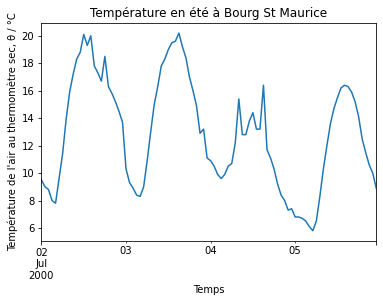

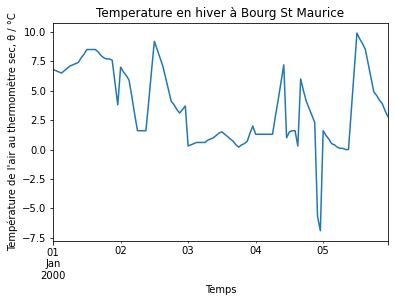

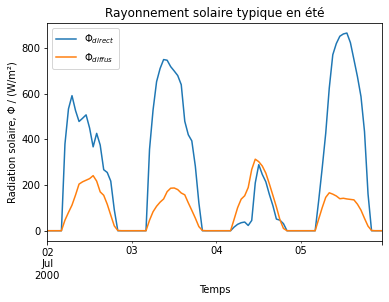

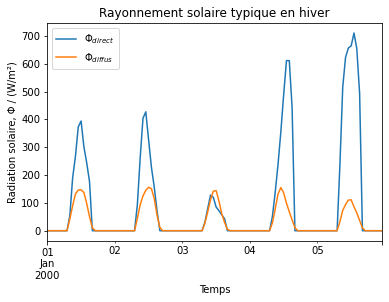

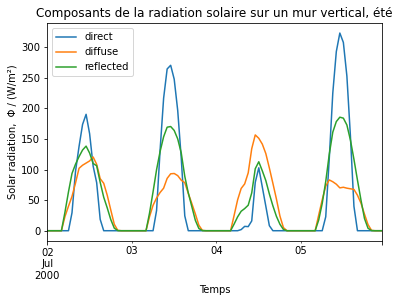

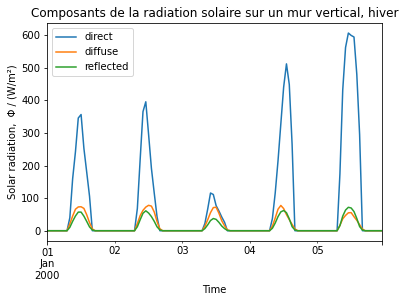

b =  [10.  0.  0.  0.  0.  0.  0.  0. 10.  0. 10. 20.]
f =  [1. 0. 0. 0. 1. 0. 1. 1.]
y =  [0. 0. 0. 0. 0. 0. 1. 0.]
θ = [10. 10. 10. 10. 10. 10. 10. 10.] °C
u = [10 10 10 20  0  0  0  0]
yss = [10.] °C
Max error between DAE and state-space: 0.00e+00 °C


In [1]:
%run "state-space.ipynb"

Nous commençons par calculer les valeurs propres de la matrice A pour obtenir les constantes de temps nécessaires à la simulation dynamique. 

In [2]:
λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As
λ = np.sort(λ)

In [3]:
print('Time constants:') 
print([f'{T:.2f} s' for T in -1 / λ])

print('\n2 x Time constants:') 
print([f'{T:.2f} s' for T in -2 / λ])

dtmax = 2 * min(-1. / λ)
print(f'\nMaximum time step: {dtmax:.2f} s = {dtmax / 60:.2f} min')

Time constants:
['929.81 s', '3577.24 s', '8547.20 s', '44267.74 s']

2 x Time constants:
['1859.62 s', '7154.49 s', '17094.40 s', '88535.48 s']

Maximum time step: 1859.62 s = 30.99 min


On défine ensuite le pas du temps qui doit être plus petit que le pas de temps maximum trouvé à fin d'avoir stabilité dans les calculs numériques.

In [4]:
# time step
dt =  480 # s np.floor(dtmax / 60) * 60 
print(f'dt = {dt} s = {dt / 60:.0f} min')

dt = 480 s = 8 min


Nous définissons le temps de stabilisation du modèle afin de choisir un temps de simulation approprié pour obtenir une solution stable.

In [5]:
# settling time
time_const = np.array([int(x) for x in sorted(-1 / λ)])
print('4 * Time constants: \n', 4 * time_const, 's \n')

t_settle = 4 * max(-1 / λ)
print(f'Settling time: \
{t_settle:.0f} s = \
{t_settle / 60:.1f} min = \
{t_settle / (3600):.2f} h = \
{t_settle / (3600 * 24):.2f} days')

4 * Time constants: 
 [  3716  14308  34188 177068] s 

Settling time: 177071 s = 2951.2 min = 49.19 h = 2.05 days


In [6]:
# Step response
# -------------
# duration: next multiple of 3600 s that is larger than t_settle
duration = np.ceil(t_settle / 3600) * 3600
n = int(np.floor(duration / dt))    # number of time steps
t = np.arange(0, n * dt, dt)        # time vector for n time steps

print(f'Duration = {duration} s')
print(f'Number of time steps = {n}')
# pd.DataFrame(t, columns=['time'])

Duration = 180000.0 s
Number of time steps = 375


In [7]:
# input vector
u = np.zeros([n, 8])                # u = [To To To Tisp Φo Φi Qa Φa]
u[:, 0:3] = 10 * np.ones([n, 3])    # To = 10 for n time steps
u[:, 3] = 20 * np.ones([n])         # Tisp = 20 for n time steps

pd.DataFrame(u)

,0,1,2,3,4,5,6,7
0,10.0,10.0,10.0,20.0,0.0,0.0,0.0,0.0
1,10.0,10.0,10.0,20.0,0.0,0.0,0.0,0.0
2,10.0,10.0,10.0,20.0,0.0,0.0,0.0,0.0
3,10.0,10.0,10.0,20.0,0.0,0.0,0.0,0.0
4,10.0,10.0,10.0,20.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
370,10.0,10.0,10.0,20.0,0.0,0.0,0.0,0.0
371,10.0,10.0,10.0,20.0,0.0,0.0,0.0,0.0
372,10.0,10.0,10.0,20.0,0.0,0.0,0.0,0.0
373,10.0,10.0,10.0,20.0,0.0,0.0,0.0,0.0


In [8]:
# initial conditions
n_s = As.shape[0]                      # number of state variables
θ_exp = np.zeros([n_s, t.shape[0]])    # explicit Euler in time t
θ_imp = np.zeros([n_s, t.shape[0]])    # implicit Euler in time t

# time integration
I = np.eye(n_s)                        # identity matrix

for k in range(n - 1):
    θ_exp[:, k + 1] = (I + dt * As) @ θ_exp[:, k]\
        + dt * Bs @ u[k, :]
    θ_imp[:, k + 1] = np.linalg.inv(I - dt * As) @ (θ_imp[:, k]\
        + dt * Bs @ u[k, :])  

Les sorties attendues pour les méthodes numériques Euler explicit et implicit.

In [9]:
# outputs
y_exp = Cs @ θ_exp + Ds @  u.T
y_imp = Cs @ θ_imp + Ds @  u.T

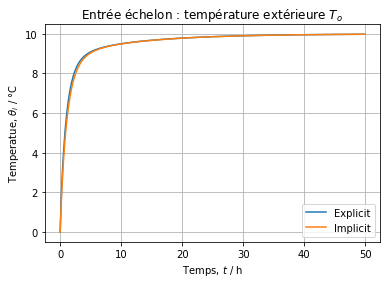

In [10]:
fig, ax = plt.subplots()
ax.plot(t / 3600, y_exp.T, t / 3600, y_imp.T)
ax.set(xlabel='Temps, $t$ / h',
       ylabel='Temperatue, $θ_i$ / °C',
       title='Entrée échelon : température extérieure $T_o$')
ax.legend(['Explicit', 'Implicit'])
ax.grid()
plt.show()

In [11]:
print('Steady-state indoor temperature obtained with:')
print(f'- DAE model: {float(θ[6]):.4f} °C')
print(f'- state-space model: {float(yss):.4f} °C')
print(f'- steady-state response to step input: {float(y_exp[:, -2]):.4f} °C')

Steady-state indoor temperature obtained with:
- DAE model: 10.0000 °C
- state-space model: 10.0000 °C
- steady-state response to step input: 9.9814 °C


In [12]:
start_date = '01-01 12:00:00'
end_date = '01-07 18:00:00'

In [13]:
start_date = '2000-' + start_date
end_date = '2000-' + end_date
print(f'{start_date} \tstart date')
print(f'{end_date} \tend date')

2000-01-01 12:00:00 	start date
2000-01-07 18:00:00 	end date


In [14]:
filename = './weather_data/FRA_AR_Bourg-St-Maurice.074970_TMYx.2007-2021.epw'
[data, meta] = dm4bem.read_epw(filename, coerce_year=None)
weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
del data

In [15]:
weather.index = weather.index.map(lambda t: t.replace(year=2000))
weather = weather.loc[start_date:end_date]

In [16]:
surface_orientation = {'slope': 90,
                       'azimuth': 0,
                       'latitude': 45}
albedo = 0.2
rad_surf = dm4bem.sol_rad_tilt_surf(
    weather, surface_orientation, albedo)
# pd.DataFrame(rad_surf)

In [17]:
rad_surf['Φtot'] = rad_surf.sum(axis=1)

In [18]:
# resample weather data
data = pd.concat([weather['temp_air'], rad_surf['Φtot']], axis=1)
data = data.resample(str(dt) + 'S').interpolate(method='linear')
data = data.rename(columns={'temp_air': 'To'})
data = data.rename_axis('Time')
pd.DataFrame(data)

,To,Φtot
Time,,
2000-01-01 12:00:00+01:00,0.8,833.5
2000-01-01 12:08:00+01:00,0.7,814.8
2000-01-01 12:16:00+01:00,0.6,796.0
2000-01-01 12:24:00+01:00,0.4,777.3
2000-01-01 12:32:00+01:00,0.3,758.5
...,...,...
2000-01-07 17:28:00+01:00,-0.5,2.1
2000-01-07 17:36:00+01:00,-0.7,1.5
2000-01-07 17:44:00+01:00,-0.9,1.0


In [19]:
data['Ti'] = 20 * np.ones(data.shape[0])
data['Qa'] = 0 * np.ones(data.shape[0])
pd.DataFrame(data)

,To,Φtot,Ti,Qa
Time,,,,
2000-01-01 12:00:00+01:00,0.8,833.5,20.0,0.0
2000-01-01 12:08:00+01:00,0.7,814.8,20.0,0.0
2000-01-01 12:16:00+01:00,0.6,796.0,20.0,0.0
2000-01-01 12:24:00+01:00,0.4,777.3,20.0,0.0
2000-01-01 12:32:00+01:00,0.3,758.5,20.0,0.0
...,...,...,...,...
2000-01-07 17:28:00+01:00,-0.5,2.1,20.0,0.0
2000-01-07 17:36:00+01:00,-0.7,1.5,20.0,0.0
2000-01-07 17:44:00+01:00,-0.9,1.0,20.0,0.0


In [20]:
# input vector
To = data['To']
Ti = data['Ti']
Φo = α_wSW * wall['Surface']['Layer_out'] * data['Φtot']
Φi = τ_gSW * α_wSW * wall['Surface']['Glass'] * data['Φtot']
Qa = data['Qa']
Φa = α_gSW * wall['Surface']['Glass'] * data['Φtot']

u = pd.concat([To, To, To, Ti, Φo, Φi, Qa, Φa], axis=1)
u.columns.values[[4, 5, 7]] = ['Φo', 'Φi', 'Φa']
pd.DataFrame(u)

,To,To,To,Ti,Φo,Φi,Qa,Φa
Time,,,,,,,,
2000-01-01 12:00:00+01:00,0.8,0.8,0.8,20.0,67548.9,4617.9,0.0,10262.0
2000-01-01 12:08:00+01:00,0.7,0.7,0.7,20.0,66030.0,4514.1,0.0,10031.3
2000-01-01 12:16:00+01:00,0.6,0.6,0.6,20.0,64511.1,4410.2,0.0,9800.5
2000-01-01 12:24:00+01:00,0.4,0.4,0.4,20.0,62992.1,4306.4,0.0,9569.8
2000-01-01 12:32:00+01:00,0.3,0.3,0.3,20.0,61473.2,4202.6,0.0,9339.0
...,...,...,...,...,...,...,...,...
2000-01-07 17:28:00+01:00,-0.5,-0.5,-0.5,20.0,166.4,11.4,0.0,25.3
2000-01-07 17:36:00+01:00,-0.7,-0.7,-0.7,20.0,124.8,8.5,0.0,19.0
2000-01-07 17:44:00+01:00,-0.9,-0.9,-0.9,20.0,83.2,5.7,0.0,12.6


In [21]:
θ_exp = 20 * np.ones([As.shape[0], u.shape[0]])

In [22]:
for k in range(u.shape[0] - 1):
    θ_exp[:, k + 1] = (I + dt * As) @ θ_exp[:, k]\
        + dt * Bs @ u.iloc[k, :]

In [23]:
y_exp = Cs @ θ_exp + Ds @ u.to_numpy().T
q_HVAC = Kp * (data['Ti'] - y_exp[0, :]) #Kp

In [24]:
data['θi_exp'] = y_exp.T
data['q_HVAC'] = q_HVAC.T

## Sortie de la température intérieure par rapport à la température extérieure et du système HVAC

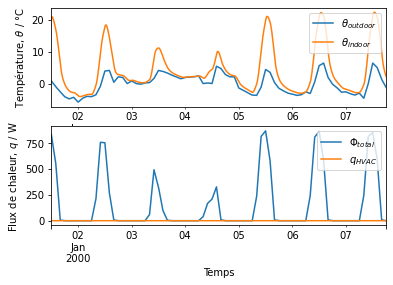

In [25]:
fig, axs = plt.subplots(2, 1)

data[['To', 'θi_exp']].plot(ax=axs[0],
                            xticks=[],
                            ylabel='Température, $θ$ / °C')
axs[0].legend(['$θ_{outdoor}$', '$θ_{indoor}$'],
              loc='upper right')

data[['Φtot', 'q_HVAC']].plot(ax=axs[1],
                              ylabel='Flux de chaleur, $q$ / W')
axs[1].set(xlabel='Temps')
axs[1].legend(['$Φ_{total}$', '$q_{HVAC}$'],
             loc='upper right')
plt.show()

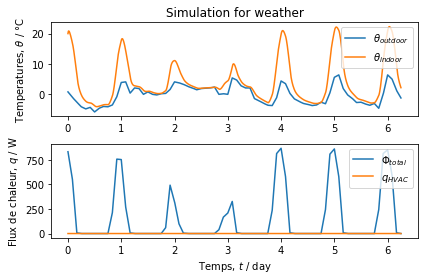

In [26]:
t = dt * np.arange(data.shape[0])   # time vector

fig, axs = plt.subplots(2, 1)
# plot outdoor and indoor temperature
axs[0].plot(t / 3600 / 24, data['To'], label='$θ_{outdoor}$')
axs[0].plot(t / 3600 / 24, y_exp[0, :], label='$θ_{indoor}$')
axs[0].set(ylabel='Temperatures, $θ$ / °C',
           title='Simulation for weather')
axs[0].legend(loc='upper right')

# plot total solar radiation and HVAC heat flow
axs[1].plot(t / 3600 / 24, data['Φtot'], label='$Φ_{total}$')
axs[1].plot(t / 3600 / 24, q_HVAC, label='$q_{HVAC}$')
axs[1].set(xlabel='Temps, $t$ / day',
           ylabel='Flux de chaleur, $q$ / W')
axs[1].legend(loc='upper right')

fig.tight_layout()

# Discussion

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem
import tuto

In [28]:
weather_file = './weather_data/FRA_AR_Bourg-St-Maurice.074970_TMYx.2007-2021.epw'
start_date = '2000-01-01 12:00:00'
end_date = '2000-03-04 18:00:00'

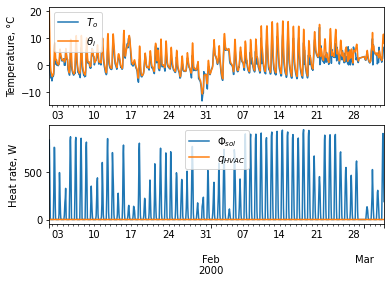

In [29]:
Tisp = 20
y, q_HVAC, data = tuto.P_control(
    weather_file, start_date, end_date, dt,
    As, Bs, Cs, Ds, Kp, Tisp)
tuto.plot_results(y, q_HVAC, data)

## Contrôleur parfait 

In [30]:
Kp = 1e3    # P-controler gain, Kp -> ∞

In [31]:
TCa = tuto.thermal_circuit(Kp)

In [32]:
[As, Bs, Cs, Ds] = dm4bem.tc2ss(
    TCa['A'], TCa['G'], TCa['C'], TCa['b'], TCa['f'], TCa['y'])

In [33]:
dtmax = min(-2. / np.linalg.eig(As)[0])
dtmax = -2. / min(np.linalg.eig(As)[0])
print(f'Maximum time step: {dtmax:.2f} s')

Maximum time step: 730.10 s


In [34]:
dt = 50   # [s] simulation time step
print(f'dt = {dt} s')

dt = 50 s


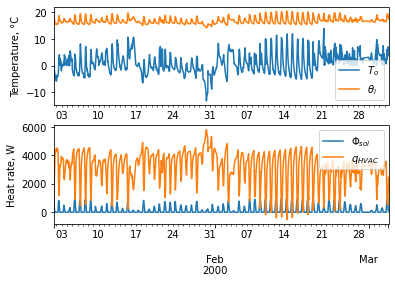

In [35]:
y, q_HVAC, data = tuto.P_control(
    weather_file, start_date, end_date, dt,
    As, Bs, Cs, Ds, Kp, Tisp)
tuto.plot_results(y, q_HVAC, data)

La dernière figure montre que, lorsque le régulateur est "parfait", la température intérieure suit le point de consigne de la température intérieure et que le débit du système HVAC a des valeurs positives et négatives (c'est-à-dire qu'il s'agit d'un système qui fournit du chauffage et du refroidissement).

# [Simulation dynamique : changer entre modèles](heat-cool.ipynb)

# [Simulation dynamique : Contrôleur avec feedback](feedback_control.ipynb)


---